# 4/17/23

For analysis of sensor vs. endogenous editing.

Adapting NGS_analysis_clean_v3.ipynb for detecting endogenous edits. Need to first separate out the reads and put them in the correct orientation.

This notebook is built for working with fastq-join'd reads...

In [4]:
# functions from utils.py
from collections import defaultdict
import gzip
from Bio.Align import PairwiseAligner
import numpy as np
import matplotlib.pyplot as plt
import ahocorasick_rs
import Bio.Seq
import csv
import pandas as pd
import seaborn as sns


#from config import *

def fastq_reader(fname, gz=False):
    _open = gzip.open if gz else open
    proc_read = (lambda line: line.strip().decode()) if gz else (lambda line: line.strip())
    proc_qual = (lambda line: line.strip()) if gz else (lambda line: line.strip().encode('utf-8'))
    with _open(fname, 'r') as f:
        for i, line in enumerate(f):
            if i % 4 == 0:
                identifier = proc_read(line)
            elif i % 4 == 1:
                read = proc_read(line)
            elif i % 4 == 3:
                quality = proc_qual(line)
                yield identifier, read, quality


def make_aligner():
    aligner = PairwiseAligner()
    aligner.mode = 'global'
    aligner.match_score = MATCH_SCORE
    aligner.mismatch_score = MISMATCH_SCORE
    aligner.open_gap_score = OPEN_GAP_SCORE
    aligner.extend_gap_score = EXTEND_GAP_SCORE
    aligner.target_end_gap_score = TARGET_END_GAP_SCORE
    aligner.query_end_gap_score = QUERY_END_GAP_SCORE
    return aligner

In [2]:
#settings for alignment, etc.

GZ = False #True when files are gzipped

# Minimum average read quality
MIN_QUALITY = 30 #originally set to 30

R1_CUTOFF = 15 # R1_anchor alignment score cutoff
R2_CUTOFF = 15 # R2_anchor alignment score cutoff

SPACER_CUTOFF = 16 # Spacer alignment score cutoff
#EXTENSION_CUTOFF = Needs to be dependent on the size of the 3' extension...

#R1_ANCHOR = 'CTTGTGGAAAGGACGAAACACC'  # Left sequence to anchor to
#R2_ANCHOR = 'CAACCAACGCTATCGGCATGG'  # Right sequence to anchor to (complementary strand)
R1_ANCHOR = 'TTGTGGAAAGGACGAAACACC'
R2_ANCHOR = 'CTAGCGTTCGAGTTAGGAATT'

tevopreq1_stop_rev = str(Bio.Seq.Seq('CGCGGTTCTATCTAGTTACGCGTTAAACCAACTAGAATTTTTTT').reverse_complement())

scaff_seq = str(Bio.Seq.Seq('GTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGC').reverse_complement())

TEVO_CUTOFF = len(tevopreq1_stop_rev)-6
SCAF_CUTOFF = len(scaff_seq)-6

MIN_SPACER_LENGTH = 16 # Minimum length of spacer
MIN_SITE_LENGTH = 200 # Minimum length of edit site & tevo stop region...

# Alignment parameters (Needleman-Wunsch)
MATCH_SCORE = 1
MISMATCH_SCORE = -0.5
OPEN_GAP_SCORE = -5
EXTEND_GAP_SCORE = -0.1
TARGET_END_GAP_SCORE = 0
QUERY_END_GAP_SCORE = 0

Goal = 

1) filter poor quality reads
2) identify which exon read corresponds to (if any)
3) put reads in correct orientation
4) save reads + classification information

In [26]:
#read processing algorithm
aligner = make_aligner()

class readout: pass

def read_processor_join2(q1, r1, anchors, MIN_QUALITY,MIN_SPACER_LENGTH, MIN_SITE_LENGTH, 
R1_ANCHOR, R2_ANCHOR, R1_CUTOFF, R2_CUTOFF, aligner):

    """
    Takes a in fastq-join'd read and returns identity of the read
    (i.e. which subpool it belongs to based on "anchors" list)

    """
    #initializing information for readout:
    readout.extension = 'none'
    #readout.extension_id = 'none'
    readout.proto = 'none'
    #readout.proto_id = 'none'
    readout.classification = 'placeholder'
    readout.offset_1 = 'none'
    readout.offset_2 = 'none'
    readout.offset_3 = 'none'
    readout.offset_4 = 'none'
    readout.orientation = 'none'


    #--------------first let's filter poor quality reads...
    qual = (np.frombuffer(q1, dtype=np.uint8) - 33).mean()
    readout.qual = qual
    if qual < MIN_QUALITY: 
        readout.classification = 'bad quality'
        return readout

    
    #--------------now lets determine the orientation of the read and find R1/R2 Anchors...---------------
    counter=False
    for i, val in enumerate(anchors):
        if val in r1[:50]:


            readout.orientation = 'F'

            #flip the read to the correct orientation
            readout.r1 = r1 #deal with flipping after the fact?
            readout.classification = i

            return readout
        
            counter=True

    if counter==False:
        readout.r2 = str(Bio.Seq.Seq(r1).reverse_complement())
        for i, val in enumerate(anchors):
            if val in readout.r2[:50]:


                readout.orientation = 'R'
                readout.r1 = readout.r2 
                readout.classification = i

                return readout
        
            
    #if none are found
    readout.classification = 'not found'
    readout.r1 = 'none'


                
    return readout

In [27]:
def extraction_filtration(anchors, files, labels, breakpoint=False):

    """
    Takes in reads and returns processed csv file that contains each of the 
    pertinent components, classification

    breakpoint = # of reads to process...
    Processing joined reads (fastq-join)...
    """


    
    header = ['read_id', 'classification', 'original_orientation', 'read_F']



    for i in range(len(files)):
        #list of joined reads...

        #picking the correct files and labels
        R1_FILE = files[i]
        file_id = labels[i]

        #for now outname = label
        outname = file_id
        file = open(outname + '.csv', 'w+', newline ='')

        #file = open('g4g.csv', 'a+', newline ='')
        with file:   
            write = csv.writer(file)
            write.writerows([header])

            #iterating through the reads...
            for i, (id1, r1, q1) in enumerate(fastq_reader(R1_FILE, gz=GZ)):


                #iterating through the paired reads
                read_processor_join2(q1, r1, anchors, MIN_QUALITY,MIN_SPACER_LENGTH, MIN_SITE_LENGTH, 
                R1_ANCHOR, R2_ANCHOR, R1_CUTOFF, R2_CUTOFF, aligner)
                

                #from readout, get the protospacer, etc, and other information...
                #should also return a list of the unique sensors/protos/etc in the same folder/directory...

                

                out = [id1,
                readout.classification,
                readout.orientation,
                readout.r1,
              ]

                write.writerows([out])

                #dummy_saver.append(out)
        
                
                if breakpoint != False:
                    if i>breakpoint:
                        break
        

        print('complete with: ' + file_id)

    #return dict(zip(range(len(unique_protos)), unique_protos))
    

# working with actual files 

In [311]:
d3 = '/Users/samgould/Desktop/FSR Lab/sequencing_data/2023_4_17_SG_sensor_vs_endogenous/00_fastq/fastq-join/D3-endogenous-pool_join.fastq'
d7 = '/Users/samgould/Desktop/FSR Lab/sequencing_data/2023_4_17_SG_sensor_vs_endogenous/00_fastq/fastq-join/D7-endogenous-pool_join.fastq'

files = [d3, d7]
labels = ['D3_endogenous', 'D7_endogenous']

sensor = pd.read_csv('D7_a549_sensor_edit_perc.csv')
sensor

,index,impact index,gene,chr,start,end,variant_type,ref_allele,mut_allele,PAM location,...,homology_overhang_true,error_classification,PBS_RTT_3to5,Prep_number,matching_ext_idx,WT,correct,other,num_reads,corr_perc
0,7,0,TP53,chr17,7578406,7578406,SNP,C,T,7578410,...,22,no error,CATGACGGAGGTTGTGAGGCACTGCCCCCACCATGAGCGCTGC,38,[0],19422.0,505.0,1160.0,21087.0,2.394840
1,2302,97,TP53,chr17,7577506,7577506,SNP,C,A,7577499,...,15,no error,GTGGCTCCTGACCTGGAGTATTCCAGTGTGATGAT,28,[2],27790.0,1134.0,1908.0,30832.0,3.677997
2,8132,346,TP53,chr17,7577544,7577544,SNP,A,C,7577553,...,17,no error,AACAGTTCCTGCATGGGCGGCAGGAACCGGAGGCCCATCC,33,[7],31021.0,534.0,1730.0,33285.0,1.604326
3,10430,450,TP53,chr17,7577085,7577085,SNP,C,G,7577084,...,7,no error,GACCGGCGCACACAGGAAGA,36,[9],1488.0,7482.0,985.0,9955.0,75.158212
4,14403,616,TP53,chr17,7578423,7578423,SNP,C,A,7578421,...,8,no error,TCACAGCACATTACGGAGGT,21,[16],13647.0,5042.0,1438.0,20127.0,25.050927
5,15805,677,TP53,chr17,7579359,7579359,SNP,G,C,7579366,...,9,no error,ACCAGGGCAGCTACGGTTTCGGTCTGGGCT,13,[17],23452.0,908.0,1618.0,25978.0,3.495265
6,19188,826,TP53,chr17,7578397,7578397,SNP,T,C,7578410,...,13,no error,GACGGAGGTTGTGAGGCGCTGCCCCCGCCATGAGCGCTGC,40,[22],20456.0,7319.0,1784.0,29559.0,24.760648
7,27907,1228,TP53,chr17,7577507,7577509,ONP,TTC,CTC,7577499,...,4,no error,GTGGCTCCTGACCTGGAGTCCTCCA,17,[31],22045.0,35.0,1766.0,23846.0,0.146775


In [312]:
primers = pd.read_csv('/Users/samgould/Desktop/FSR Lab/2023-4-17/primers.csv')
primers

#these are going to be used as the anchors for identifying reads and sorting them accordingly...

,primer,seq,Sample
0,TP53_Exon_7A_R_Barcode_1,TCTCTCTCATCTTGGGCCTGTGTTATCTC,D259Y
1,TP53_Exon_7A_R_Barcode_2,AGAGAGAGATCTTGGGCCTGTGTTATCTC,M246R
2,TP53_Exon_7A_R_Barcode_3,AATTCCGGATCTTGGGCCTGTGTTATCTC,E258E
3,TP53_Exon_5B_R_Barcode_1,TCTCTCTCCCAAGACCTGCCCTGTG,R175H
4,TP53_Exon_5B_R_Barcode_2,AGAGAGAGCCAAGACCTGCCCTGTG,M169I
5,TP53_Exon_5B_R_Barcode_3,AATTCCGGCCAAGACCTGCCCTGTG,H178R
6,TP53_Exon_8A_R,TTCCTTACTGCCTCTTGCTTC,E285Q
7,TP53_Exon_4C_R,ACCCAGGTCCAGATGAAG,R110G


In [313]:
anchors = list(primers['seq'])
anchors

['TCTCTCTCATCTTGGGCCTGTGTTATCTC',
 'AGAGAGAGATCTTGGGCCTGTGTTATCTC',
 'AATTCCGGATCTTGGGCCTGTGTTATCTC',
 'TCTCTCTCCCAAGACCTGCCCTGTG',
 'AGAGAGAGCCAAGACCTGCCCTGTG',
 'AATTCCGGCCAAGACCTGCCCTGTG',
 'TTCCTTACTGCCTCTTGCTTC',
 'ACCCAGGTCCAGATGAAG']

In [314]:
extraction_filtration(anchors, files, labels, breakpoint=False)

complete with: D3_endogenous
complete with: D7_endogenous


In [315]:
d3_df = pd.read_csv('D3_endogenous.csv')
d7_df = pd.read_csv('D7_endogenous.csv')

In [316]:
u1, c1 = np.unique(d3_df['classification'], return_counts=True)

In [317]:
u2, c2 = np.unique(d7_df['classification'], return_counts=True)


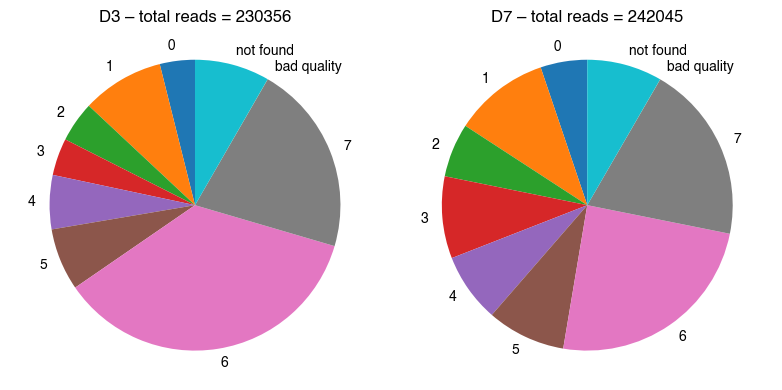

In [407]:
plt.rcParams['font.family'] = 'Helvetica'


explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(1, 2, figsize=(8,4))
ax1[0].pie(c1, labels=u1,
        shadow=False, startangle=90)

ax1[1].pie(c2, labels=u2,
        shadow=False, startangle=90)

ax1[0].axis('equal')
ax1[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1[0].set_title('D3 – total reads = ' + str(len(d3_df)))
ax1[1].set_title('D7 – total reads = ' + str(len(d7_df)))
fig1.tight_layout()
fig1.savefig('pie_endog.pdf')

In [32]:
d7_df

,read_id,classification,original_orientation,read_F
0,@A01940:202:GW230416000:1:2101:11207:1016 1:N:...,1,R,AGAGAGAGATCTTGGGCCTGTGTTATCTCCTAGGTTGGCTCTGACT...
1,@A01940:202:GW230416000:1:2101:24252:1031 1:N:...,7,R,ACCCAGGTCCAGATGAAGCTCCCAGAATGCCAGAGGCTGCTCCCCG...
2,@A01940:202:GW230416000:1:2101:24379:1031 1:N:...,7,R,ACCCAGGTCCAGATGAAGCTCCCAGAATGCCAGAGGCTGCTCCCCG...
3,@A01940:202:GW230416000:1:2101:25238:1047 1:N:...,0,R,TCTCTCTCATCTTGGGCCTGTGTTATCTCCTAGGTTGGCTCTGACT...
4,@A01940:202:GW230416000:1:2101:23366:1063 1:N:...,7,R,ACCCAGGTCCAGATGAAGCTCCCAGAATGCCAGAGGCTGCTCCCCG...
...,...,...,...,...
242040,@A01940:202:GW230416000:1:2278:31738:36949 1:N...,7,F,ACCCAGGTCCAGATGAAGCTCCCAGAATGCCAGAGGCTGCTCCCCG...
242041,@A01940:202:GW230416000:1:2278:6415:36996 1:N:...,0,R,TCTCTCTCATCTTGGGCCTGTGTTATCTCCTAGGTTGGCTCTGACT...
242042,@A01940:202:GW230416000:1:2278:27263:36996 1:N...,6,R,TTCCTTACTGCCTCTTGCTTCTCTTTTCCTATCCTGAGTAGTGGTA...
242043,@A01940:202:GW230416000:1:2278:21558:37043 1:N...,7,R,ACCCAGGTCCAGATGAAGCTCCCAGAATGCCAGAGGCTGCTCCCCG...


# function for writing fastq files from dataframe

In [104]:
primers

,primer,seq,Sample
0,TP53_Exon_7A_R_Barcode_1,TCTCTCTCATCTTGGGCCTGTGTTATCTC,D259Y
1,TP53_Exon_7A_R_Barcode_2,AGAGAGAGATCTTGGGCCTGTGTTATCTC,M246R
2,TP53_Exon_7A_R_Barcode_3,AATTCCGGATCTTGGGCCTGTGTTATCTC,E258E
3,TP53_Exon_5B_R_Barcode_1,TCTCTCTCCCAAGACCTGCCCTGTG,R175H
4,TP53_Exon_5B_R_Barcode_2,AGAGAGAGCCAAGACCTGCCCTGTG,M169I
5,TP53_Exon_5B_R_Barcode_3,AATTCCGGCCAAGACCTGCCCTGTG,H178R
6,TP53_Exon_8A_R,TTCCTTACTGCCTCTTGCTTC,E285Q
7,TP53_Exon_4C_R,ACCCAGGTCCAGATGAAG,R110G


In [105]:
anchor_6 = d7_df[d7_df['classification']=='6']

with open('anchor_6.txt', 'w') as f:

    for i, val in anchor_0.iterrows():
        name = val['read_id']
        read = val['read_F']
        fake_q = 'F'*len(read)
        f.write(name)
        f.write('\n')
        f.write(read)
        f.write('\n')
        f.write('+')
        f.write('\n')
        f.write(fake_q)
        f.write('\n')


In [106]:
anchor_6['read_F']

7         TTCCTTACTGCCTCTTGCTTCTCTTTTCCTATCCTGAGTAGTGGTA...
10        TTCCTTACTGCCTCTTGCTTCTCTTTTCCTATCCTGAGTAGTGGTA...
12        TTCCTTACTGCCTCTTGCTTCTCTTTTCCTATCCTGAGTAGTGGTA...
16        TTCCTTACTGCCTCTTGCTTCTCTTTTCCTATCCTGAGTAGTGGTA...
18        TTCCTTACTGCCTCTTGCTTCTCTTTTCCTATCCTGAGTAGTGGTA...
                                ...                        
241991    TTCCTTACTGCCTCTTGCTTCTCTTTTCCTATCCTGAGTAGTGGTA...
242028    TTCCTTACTGCCTCTTGCTTCTCTTTTCCTATCCTGAGTAGTGGTA...
242031    TTCCTTACTGCCTCTTGCTTCTCTTTTCCTATCCTGAGTAGTGGTA...
242036    TTCCTTACTGCCTCTTGCTTCTCTTTTCCTATCCTGAGTAGTGGTA...
242042    TTCCTTACTGCCTCTTGCTTCTCTTTTCCTATCCTGAGTAGTGGTA...
Name: read_F, Length: 59294, dtype: object

In [127]:
outcomes.iloc[0]['count']/len(anchor_6)

0.5006071440617937

In [70]:
sensor[sensor['HGVSp']=='p.Asp259Tyr']['protospacer']

1    GTGGCAAGTGGCTCCTGACC
Name: protospacer, dtype: object

In [158]:
anchor_6 = d7_df[d7_df['classification']=='6']
u, c = np.unique(anchor_6['read_F'], return_counts=True)

outcomes = pd.DataFrame(dict(zip(['outcome', 'count'], [u, c]))).sort_values(by='count', ascending=False)
lengths = [len(i) for i in outcomes['outcome']]
outcomes['length'] = lengths

outcomes[0:19]

,outcome,count,length
376,TTCCTTACTGCCTCTTGCTTCTCTTTTCCTATCCTGAGTAGTGGTA...,29683,199
661,TTCCTTACTGCCTCTTGCTTCTCTTTTCCTATCCTGAGTAGTGGTA...,26247,199
563,TTCCTTACTGCCTCTTGCTTCTCTTTTCCTATCCTGAGTAGTGGTA...,202,199
658,TTCCTTACTGCCTCTTGCTTCTCTTTTCCTATCCTGAGTAGTGGTA...,82,197
657,TTCCTTACTGCCTCTTGCTTCTCTTTTCCTATCCTGAGTAGTGGTA...,74,196
370,TTCCTTACTGCCTCTTGCTTCTCTTTTCCTATCCTGAGTAGTGGTA...,72,196
372,TTCCTTACTGCCTCTTGCTTCTCTTTTCCTATCCTGAGTAGTGGTA...,65,198
371,TTCCTTACTGCCTCTTGCTTCTCTTTTCCTATCCTGAGTAGTGGTA...,62,197
659,TTCCTTACTGCCTCTTGCTTCTCTTTTCCTATCCTGAGTAGTGGTA...,47,198
434,TTCCTTACTGCCTCTTGCTTCTCTTTTCCTATCCTGAGTAGTGGTA...,42,198


In [160]:
print(outcomes.iloc[1]['outcome'])

TTCCTTACTGCCTCTTGCTTCTCTTTTCCTATCCTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCGTGTTTGTGCCTGTCCTGGGAGAGACCGGCGCACAGAGGAAGAGAATCTCCGCAAGAAAGGGGAGCCTCACCACGAGCTGCCCCCAGGGAGCACTAAGCGAGGTAAGCAAGCAGGACAAGAAG


In [323]:
#should probably double check these
#and come up with a better way to do it


wtexon7_1 = 'TCTCTCTC' + 'atcttgggcctgtgttatctcctagGTTGGCTCTGACTGTACCACCATCCACTACAACTACATGTGTAACAGTTCCTGCATGGGCGGCATGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCAGgtcaggagccacttgccac'.upper()
wtexon7_2 = 'AGAGAGAG' + 'atcttgggcctgtgttatctcctagGTTGGCTCTGACTGTACCACCATCCACTACAACTACATGTGTAACAGTTCCTGCATGGGCGGCATGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCAGgtcaggagccacttgccac'.upper()
wtexon7_3 = 'AATTCCGG' + 'atcttgggcctgtgttatctcctagGTTGGCTCTGACTGTACCACCATCCACTACAACTACATGTGTAACAGTTCCTGCATGGGCGGCATGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCAGgtcaggagccacttgccac'.upper()
wtexon5_1 = 'TCTCTCTC' + 'CCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACACCCCCGCCCGGCACCCGCGTCCGCGCCATGGCCATCTACAAGCAGTCACAGCACATGACGGAGGTTGTGAGGCGCTGCCCCCACCATGAGCGCTGCTCAGATAGCGATGgtgagcagctggggctggagagacgacagggctggttgcccagggtccccaggcctctgattcctcactgattgc'.upper()
wtexon5_2 = 'AGAGAGAG' + 'CCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACACCCCCGCCCGGCACCCGCGTCCGCGCCATGGCCATCTACAAGCAGTCACAGCACATGACGGAGGTTGTGAGGCGCTGCCCCCACCATGAGCGCTGCTCAGATAGCGATGgtgagcagctggggctggagagacgacagggctggttgcccagggtccccaggcctctgattcctcactgattgc'.upper()
wtexon5_3 = 'AATTCCGG' + 'CCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACACCCCCGCCCGGCACCCGCGTCCGCGCCATGGCCATCTACAAGCAGTCACAGCACATGACGGAGGTTGTGAGGCGCTGCCCCCACCATGAGCGCTGCTCAGATAGCGATGgtgagcagctggggctggagagacgacagggctggttgcccagggtccccaggcctctgattcctcactgattgc'.upper()
wtexon8 = 'TTCCTTACTGCCTCTTGCTTCTCTTTTCCTATCCTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCGTGTTTGTGCCTGTCCTGGGAGAGACCGGCGCACAGAGGAAGAGAATCTCCGCAAGAAAGGGGAGCCTCACCACGAGCTGCCCCCAGGGAGCACTAAGCGAGGTAAGCAAGCAGGACAAGAAG'
wtexon4 = 'ACCCAGGTCCAGATGAAGCTCCCAGAATGCCAGAGGCTGCTCCCCGCGTGGCCCCTGCACCAGCAGCTCCTACACCGGCGGCCCCTGCACCAGCCCCCTCCTGGCCCCTGTCATCTTCTGTCCCTTCCCAGAAAACCTACCAGGGCAGCTACGGTTTCCGTCTGGGCTTCTTGCATTCTGGGACAGCCAAGTCTGTGACTTGCACGGTCAGTTGCCCTGAGGGGCTGGCTTCCATGAGACTTCA'
#includes amino acid 73 polymorphism found in A549 cells (see previous notes)

corr7_1 = 'TCTCTCTCATCTTGGGCCTGTGTTATCTCCTAGGTTGGCTCTGACTGTACCACCATCCACTACAACTACATGTGTAACAGTTCCTGCATGGGCGGCATGAACCGGAGGCCCATCCTCACCATCATCACACTGGAATACTCCAGGTCAGGAGCCACTTGCCAC'
corr7_2 = 'AGAGAGAGATCTTGGGCCTGTGTTATCTCCTAGGTTGGCTCTGACTGTACCACCATCCACTACAACTACATGTGTAACAGTTCCTGCATGGGCGGCAGGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCAGGTCAGGAGCCACTTGCCAC'
corr7_3 = 'AATTCCGGATCTTGGGCCTGTGTTATCTCCTAGGTTGGCTCTGACTGTACCACCATCCACTACAACTACATGTGTAACAGTTCCTGCATGGGCGGCATGAACCGGAGGCCCATCCTCACCATCATCACACTGGAGGACTCCAGGTCAGGAGCCACTTGCCAC'
corr5_1 = 'TCTCTCTCCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACACCCCCGCCCGGCACCCGCGTCCGCGCCATGGCCATCTACAAGCAGTCACAGCACATGACGGAGGTTGTGAGGCACTGCCCCCACCATGAGCGCTGCTCAGATAGCGATGGTGAGCAGCTGGGGCTGGAGAGACGACAGGGCTGGTTGCCCAGGGTCCCCAGGCCTCTGATTCCTCACTGATTGC'
corr5_2 = 'AGAGAGAGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACACCCCCGCCCGGCACCCGCGTCCGCGCCATGGCCATCTACAAGCAGTCACAGCACATTACGGAGGTTGTGAGGCGCTGCCCCCACCATGAGCGCTGCTCAGATAGCGATGGTGAGCAGCTGGGGCTGGAGAGACGACAGGGCTGGTTGCCCAGGGTCCCCAGGCCTCTGATTCCTCACTGATTGC'
corr5_3 = 'AATTCCGGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACACCCCCGCCCGGCACCCGCGTCCGCGCCATGGCCATCTACAAGCAGTCACAGCACATGACGGAGGTTGTGAGGCGCTGCCCCCGCCATGAGCGCTGCTCAGATAGCGATGGTGAGCAGCTGGGGCTGGAGAGACGACAGGGCTGGTTGCCCAGGGTCCCCAGGCCTCTGATTCCTCACTGATTGC'
corr8 = 'TTCCTTACTGCCTCTTGCTTCTCTTTTCCTATCCTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCGTGTTTGTGCCTGTCCTGGGAGAGACCGGCGCACACAGGAAGAGAATCTCCGCAAGAAAGGGGAGCCTCACCACGAGCTGCCCCCAGGGAGCACTAAGCGAGGTAAGCAAGCAGGACAAGAAG'
corr4 = 'ACCCAGGTCCAGATGAAGCTCCCAGAATGCCAGAGGCTGCTCCCCGCGTGGCCCCTGCACCAGCAGCTCCTACACCGGCGGCCCCTGCACCAGCCCCCTCCTGGCCCCTGTCATCTTCTGTCCCTTCCCAGAAAACCTACCAGGGCAGCTACGGTTTCGGTCTGGGCTTCTTGCATTCTGGGACAGCCAAGTCTGTGACTTGCACGGTCAGTTGCCCTGAGGGGCTGGCTTCCATGAGACTTCA'

wt_seqs = [wtexon7_1, wtexon7_2, wtexon7_3, wtexon5_1, wtexon5_2, wtexon5_3, wtexon8, wtexon4]
corr_edit = [corr7_1, corr7_2, corr7_3, corr5_1, corr5_2, corr5_3, corr8, corr4]
primers['wt_seq'] = wt_seqs
primers['correct_edit'] = corr_edit

primers

,primer,seq,Sample,wt_seq,correct_edit
0,TP53_Exon_7A_R_Barcode_1,TCTCTCTCATCTTGGGCCTGTGTTATCTC,D259Y,TCTCTCTCATCTTGGGCCTGTGTTATCTCCTAGGTTGGCTCTGACT...,TCTCTCTCATCTTGGGCCTGTGTTATCTCCTAGGTTGGCTCTGACT...
1,TP53_Exon_7A_R_Barcode_2,AGAGAGAGATCTTGGGCCTGTGTTATCTC,M246R,AGAGAGAGATCTTGGGCCTGTGTTATCTCCTAGGTTGGCTCTGACT...,AGAGAGAGATCTTGGGCCTGTGTTATCTCCTAGGTTGGCTCTGACT...
2,TP53_Exon_7A_R_Barcode_3,AATTCCGGATCTTGGGCCTGTGTTATCTC,E258E,AATTCCGGATCTTGGGCCTGTGTTATCTCCTAGGTTGGCTCTGACT...,AATTCCGGATCTTGGGCCTGTGTTATCTCCTAGGTTGGCTCTGACT...
3,TP53_Exon_5B_R_Barcode_1,TCTCTCTCCCAAGACCTGCCCTGTG,R175H,TCTCTCTCCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACA...,TCTCTCTCCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACA...
4,TP53_Exon_5B_R_Barcode_2,AGAGAGAGCCAAGACCTGCCCTGTG,M169I,AGAGAGAGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACA...,AGAGAGAGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACA...
5,TP53_Exon_5B_R_Barcode_3,AATTCCGGCCAAGACCTGCCCTGTG,H178R,AATTCCGGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACA...,AATTCCGGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACA...
6,TP53_Exon_8A_R,TTCCTTACTGCCTCTTGCTTC,E285Q,TTCCTTACTGCCTCTTGCTTCTCTTTTCCTATCCTGAGTAGTGGTA...,TTCCTTACTGCCTCTTGCTTCTCTTTTCCTATCCTGAGTAGTGGTA...
7,TP53_Exon_4C_R,ACCCAGGTCCAGATGAAG,R110G,ACCCAGGTCCAGATGAAGCTCCCAGAATGCCAGAGGCTGCTCCCCG...,ACCCAGGTCCAGATGAAGCTCCCAGAATGCCAGAGGCTGCTCCCCG...


In [324]:
def edit_quant(d7_df, primers):

    primers2 = primers.copy()
    out_counts = np.zeros((3,8))
#wt, correct, total, corr_perc


    for i in range(8):
        anchor = d7_df[d7_df['classification']==str(i)]
        u, c = np.unique(anchor['read_F'], return_counts=True)

        outcomes = pd.DataFrame(dict(zip(['outcome', 'count'], [u, c]))).sort_values(by='count', ascending=False)
        
        wt_ref = primers.iloc[i]['wt_seq']
        corr_ref = primers.iloc[i]['correct_edit']

        out_counts[2][i] += len(anchor)

        for k, val in outcomes.iterrows():
            if val['outcome']==wt_ref:
                out_counts[0][i] += val['count']
            if val['outcome']==corr_ref:
                out_counts[1][i] += val['count']

            else:
                continue

        

    primers2['wt_counts'] = out_counts[0]
    primers2['corr_counts'] = out_counts[1]
    primers2['total_counts'] = out_counts[2]
    primers2['corr_perc'] = 100*out_counts[1]/out_counts[2]

    return primers2


In [325]:
d7_quant = edit_quant(d7_df, primers)
d3_quant = edit_quant(d3_df, primers)

In [332]:
d7_quant['Sample']

0    D259Y
1    M246R
2    E258E
3    R175H
4    M169I
5    H178R
6    E285Q
7    R110G
Name: Sample, dtype: object

In [347]:
mutations_endog = d7_quant['Sample']
d3_perc = d3_quant['corr_perc']
d7_perc = d7_quant['corr_perc']

endog_perc = pd.DataFrame(dict(zip(['Mutation', 'Endogenous-D3', 'Endogenous-D7'], [mutations_endog, d3_perc, d7_perc]))).set_index('Mutation')
endog_perc

a = pd.read_csv('sensor_editing_d3_d7.csv').set_index('Mutation')

g = pd.concat((endog_perc,a), axis=1).rename(columns={'A549-D3':'Sensor-D3', 'A549-D7':'Sensor-D7'})
g

,Endogenous-D3,Endogenous-D7,Sensor-D3,Sensor-D7
Mutation,,,,
D259Y,1.145972,1.607384,1.320375,3.677997
M246R,0.233045,0.213825,1.235587,1.604326
E258E,0.741811,0.896428,0.076257,0.146775
R175H,0.094687,0.267368,0.979819,2.394840
M169I,6.861187,10.675487,9.517663,25.050927
H178R,3.218925,3.752008,6.875750,24.760648
E285Q,28.312254,50.060714,33.278466,75.158212
R110G,0.921319,1.071250,1.877490,3.495265


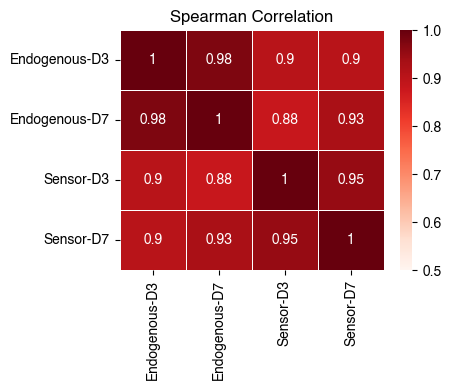

In [358]:
plt.figure(figsize=(4.7,4))
sns.heatmap(g.corr(method='spearman'), cmap='Reds', vmin=.5, annot=True, linewidth=.5)
plt.title('Spearman Correlation')
plt.tight_layout()
#plt.savefig('spearman_sensor_endog.pdf')

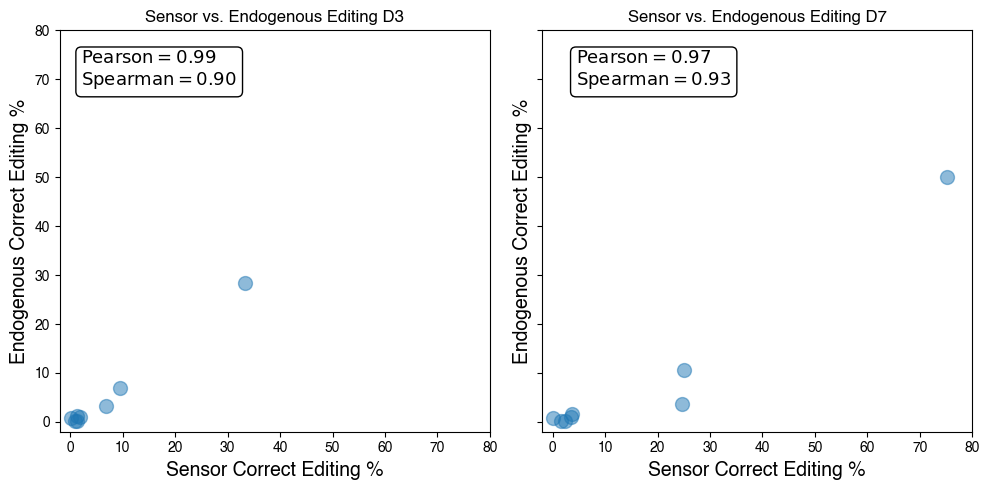

In [380]:
#df1.set_index('Mutation')
#df2.set_index('Mutation')
import scipy.stats 


fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
ax[0].scatter(g['Sensor-D3'], g['Endogenous-D3'], s=100, alpha=.5)
ax[0].set_xlim(-2,80)
ax[0].set_ylim(-2,80)

pearson = np.round(scipy.stats.pearsonr(g['Sensor-D3'], g['Endogenous-D3']).statistic, 2)
spear = np.round(scipy.stats.spearmanr(g['Sensor-D3'], g['Endogenous-D3']).statistic, 2)
textstr = '\n'.join((
    r'$\mathrm{Pearson}=%.2f$' % (pearson, ),
    r'$\mathrm{Spearman}=%.2f$' % (spear, )))

props = dict(boxstyle='round', facecolor='white', alpha=1)
ax[0].text(0.05, 0.95, textstr, transform=ax[0].transAxes, fontsize=13,
        verticalalignment='top', bbox=props)

ax[0].set_title('Sensor vs. Endogenous Editing D3')
ax[0].set_ylabel('Endogenous Correct Editing %', fontsize=14)
ax[0].set_xlabel('Sensor Correct Editing %', fontsize=14)


ax[1].scatter(g['Sensor-D7'], g['Endogenous-D7'], s=100, alpha=.5)


pearson = np.round(scipy.stats.pearsonr(g['Sensor-D7'], g['Endogenous-D7']).statistic, 2)
spear = np.round(scipy.stats.spearmanr(g['Sensor-D7'], g['Endogenous-D7']).statistic, 2)
textstr = '\n'.join((
    r'$\mathrm{Pearson}=%.2f$' % (pearson, ),
    r'$\mathrm{Spearman}=%.2f$' % (spear, )))

props = dict(boxstyle='round', facecolor='white', alpha=1)
ax[1].text(1.2, 0.95, textstr, transform=ax[0].transAxes, fontsize=13,
        verticalalignment='top', bbox=props)

ax[1].set_title('Sensor vs. Endogenous Editing D7')
ax[1].set_ylabel('Endogenous Correct Editing %', fontsize=14)
ax[1].set_xlabel('Sensor Correct Editing %', fontsize=14)

fig.tight_layout()
#fig.savefig('sensor_endog_scatter_smalld3d7.pdf')

In [395]:
g2 = g.reset_index()
g2 = g2.melt(id_vars='Mutation').rename(columns={'value':'Correct Edit %', 'variable':'Locus/Time'})
g2

,Mutation,Locus/Time,Correct Edit %
0,D259Y,Endogenous-D3,1.145972
1,M246R,Endogenous-D3,0.233045
2,E258E,Endogenous-D3,0.741811
3,R175H,Endogenous-D3,0.094687
4,M169I,Endogenous-D3,6.861187
5,H178R,Endogenous-D3,3.218925
6,E285Q,Endogenous-D3,28.312254
7,R110G,Endogenous-D3,0.921319
8,D259Y,Endogenous-D7,1.607384
9,M246R,Endogenous-D7,0.213825


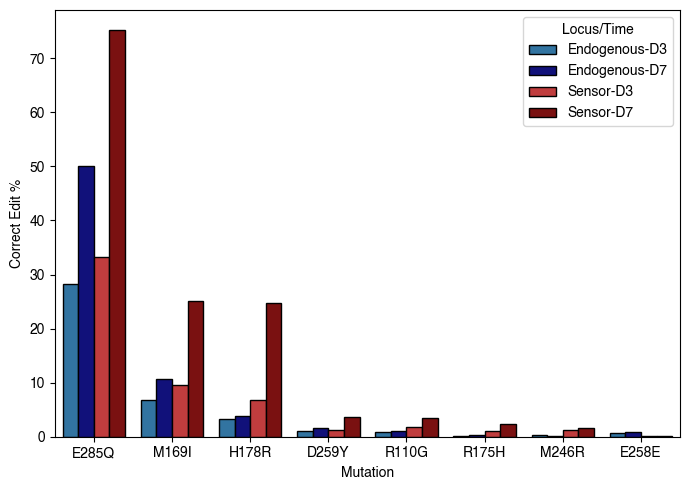

In [404]:
fig, ax = plt.subplots(figsize=(7,5))
h = g['Sensor-D7'].reset_index()
order=list(pd.DataFrame(h).sort_values(by='Sensor-D7')[::-1]["Mutation"])

sns.barplot(data = g2, y='Correct Edit %', x='Mutation', hue='Locus/Time', order=order, palette = ['tab:blue', 'darkblue', 'tab:red', 'darkred'], edgecolor='black')

fig.tight_layout()

#fig.savefig('sensor_endog_bar.pdf')

In [405]:
g

,Endogenous-D3,Endogenous-D7,Sensor-D3,Sensor-D7
Mutation,,,,
D259Y,1.145972,1.607384,1.320375,3.677997
M246R,0.233045,0.213825,1.235587,1.604326
E258E,0.741811,0.896428,0.076257,0.146775
R175H,0.094687,0.267368,0.979819,2.394840
M169I,6.861187,10.675487,9.517663,25.050927
H178R,3.218925,3.752008,6.875750,24.760648
E285Q,28.312254,50.060714,33.278466,75.158212
R110G,0.921319,1.071250,1.877490,3.495265


In [ ]:

sensor['Sample'] = ['R175H',
'D259Y',
'M246R',
'E285Q',
'M169I',
'R110G',
'H178R',
'E258E']


mut_sensor = list(sensor['Sample'])

perc_sensor = list(sensor['corr_perc'])
type1 = ['Sensor']*8


mut_endog = primers['Sample']
perc_endog = primers['corr_perc']
type2 = ['Endogenous']*8

df1 = pd.DataFrame(dict(zip(['Mutation', 'Correct Edit %', 'Locus'], [mut_sensor, perc_sensor, type1])))
df2 = pd.DataFrame(dict(zip(['Mutation', 'Correct Edit %', 'Locus'], [mut_endog, perc_endog, type2])))

df3 = pd.concat((df1, df2))


fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(data = df3, y='Correct Edit %', x='Mutation', hue='Locus', order=list(df1.sort_values(by='Correct Edit %')[::-1]["Mutation"]))

fig.tight_layout()
#fig.savefig('Comparison_sensor_endog.pdf')

,primer,seq,Sample,wt_seq,correct_edit,wt_counts,corr_counts,total_counts,corr_perc
0,TP53_Exon_7A_R_Barcode_1,TCTCTCTCATCTTGGGCCTGTGTTATCTC,D259Y,TCTCTCTCATCTTGGGCCTGTGTTATCTCCTAGGTTGGCTCTGACT...,TCTCTCTCATCTTGGGCCTGTGTTATCTCCTAGGTTGGCTCTGACT...,11878.0,202.0,12567.0,1.607384
1,TP53_Exon_7A_R_Barcode_2,AGAGAGAGATCTTGGGCCTGTGTTATCTC,M246R,AGAGAGAGATCTTGGGCCTGTGTTATCTCCTAGGTTGGCTCTGACT...,AGAGAGAGATCTTGGGCCTGTGTTATCTCCTAGGTTGGCTCTGACT...,24645.0,55.0,25722.0,0.213825
2,TP53_Exon_7A_R_Barcode_3,AATTCCGGATCTTGGGCCTGTGTTATCTC,E258E,AATTCCGGATCTTGGGCCTGTGTTATCTCCTAGGTTGGCTCTGACT...,AATTCCGGATCTTGGGCCTGTGTTATCTCCTAGGTTGGCTCTGACT...,13757.0,130.0,14502.0,0.896428
3,TP53_Exon_5B_R_Barcode_1,TCTCTCTCCCAAGACCTGCCCTGTG,R175H,TCTCTCTCCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACA...,TCTCTCTCCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACA...,20070.0,59.0,22067.0,0.267368
4,TP53_Exon_5B_R_Barcode_2,AGAGAGAGCCAAGACCTGCCCTGTG,M169I,AGAGAGAGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACA...,AGAGAGAGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACA...,14939.0,1985.0,18594.0,10.675487
5,TP53_Exon_5B_R_Barcode_3,AATTCCGGCCAAGACCTGCCCTGTG,H178R,AATTCCGGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACA...,AATTCCGGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACA...,18386.0,794.0,21162.0,3.752008
6,TP53_Exon_8A_R,TTCCTTACTGCCTCTTGCTTC,E285Q,TTCCTTACTGCCTCTTGCTTCTCTTTTCCTATCCTGAGTAGTGGTA...,TTCCTTACTGCCTCTTGCTTCTCTTTTCCTATCCTGAGTAGTGGTA...,26247.0,29683.0,59294.0,50.060714
7,TP53_Exon_4C_R,ACCCAGGTCCAGATGAAG,R110G,ACCCAGGTCCAGATGAAGCTCCCAGAATGCCAGAGGCTGCTCCCCG...,ACCCAGGTCCAGATGAAGCTCCCAGAATGCCAGAGGCTGCTCCCCG...,43466.0,513.0,47888.0,1.071250


In [310]:
df3

,Mutation,Correct Edit %,Locus
0,R175H,2.394840,Sensor
1,D259Y,3.677997,Sensor
2,M246R,1.604326,Sensor
3,E285Q,75.158212,Sensor
4,M169I,25.050927,Sensor
5,R110G,3.495265,Sensor
6,H178R,24.760648,Sensor
7,E258E,0.146775,Sensor
0,D259Y,1.607384,Endogenous
1,M246R,0.213825,Endogenous


In [390]:

sensor['Sample'] = ['R175H',
'D259Y',
'M246R',
'E285Q',
'M169I',
'R110G',
'H178R',
'E258E']


mut_sensor = list(sensor['Sample'])

perc_sensor = list(sensor['corr_perc'])
type1 = ['Sensor']*8


mut_endog = primers['Sample']
perc_endog = primers['corr_perc']
type2 = ['Endogenous']*8

df1 = pd.DataFrame(dict(zip(['Mutation', 'Correct Edit %', 'Locus'], [mut_sensor, perc_sensor, type1])))
df2 = pd.DataFrame(dict(zip(['Mutation', 'Correct Edit %', 'Locus'], [mut_endog, perc_endog, type2])))

df3 = pd.concat((df1, df2))


fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(data = df3, y='Correct Edit %', x='Mutation', hue='Locus', order=list(df1.sort_values(by='Correct Edit %')[::-1]["Mutation"]))

fig.tight_layout()
#fig.savefig('Comparison_sensor_endog.pdf')

KeyError: 'corr_perc'

In [327]:
df3

,Mutation,Correct Edit %,Locus
0,R175H,2.394840,Sensor
1,D259Y,3.677997,Sensor
2,M246R,1.604326,Sensor
3,E285Q,75.158212,Sensor
4,M169I,25.050927,Sensor
5,R110G,3.495265,Sensor
6,H178R,24.760648,Sensor
7,E258E,0.146775,Sensor
0,D259Y,1.607384,Endogenous
1,M246R,0.213825,Endogenous


In [329]:
a = pd.read_csv('sensor_editing_d3_d7.csv')


,Mutation,A549-D3,A549-D7
0,R175H,0.979819,2.394840
1,D259Y,1.320375,3.677997
2,M246R,1.235587,1.604326
3,D285Q,33.278466,75.158212
4,M159I,9.517663,25.050927
5,R110G,1.877490,3.495265
6,H178R,6.875750,24.760648
7,E258E,0.076257,0.146775


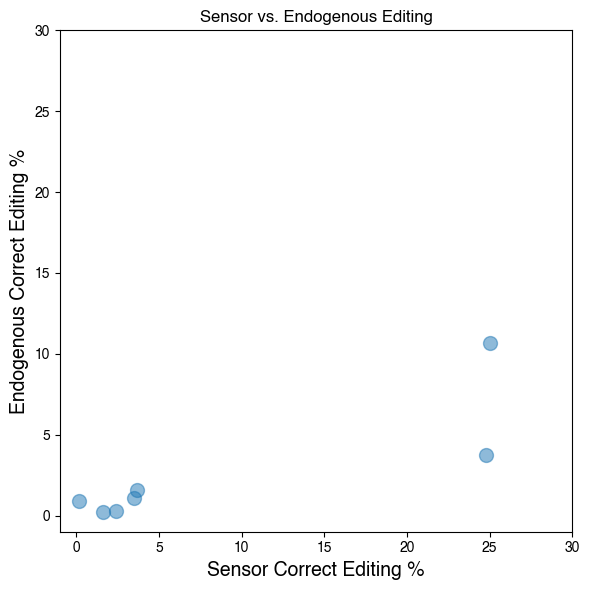

In [309]:
#df1.set_index('Mutation')
#df2.set_index('Mutation')
import scipy.stats 

sensor = df1.sort_values(by='Mutation')['Correct Edit %']
endog = df2.sort_values(by='Mutation')['Correct Edit %']


fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(sensor, endog, s=100, alpha=.5)
plt.xlim(-1,80)
plt.ylim(-1,80)

pearson = np.round(scipy.stats.pearsonr(sensor, endog).statistic, 2)
spear = np.round(scipy.stats.spearmanr(sensor, endog).statistic, 2)
textstr = '\n'.join((
    r'$\mathrm{Pearson}=%.2f$' % (pearson, ),
    r'$\mathrm{Spearman}=%.2f$' % (spear, )))

props = dict(boxstyle='round', facecolor='white', alpha=1)
ax.text(0.65, 0.13, textstr, transform=ax.transAxes, fontsize=13,
        verticalalignment='top', bbox=props)

ax.set_title('Sensor vs. Endogenous Editing')
ax.set_ylabel('Endogenous Correct Editing %', fontsize=14)
ax.set_xlabel('Sensor Correct Editing %', fontsize=14)

fig.tight_layout()
fig.savefig('sensor_endog_scatter_smaller.pdf')

In [279]:
df2.sort_values(by='Mutation')

,Mutation,Correct Edit %,Locus
0,D259Y,1.607384,Endogenous
2,E258E,0.896428,Endogenous
6,E285Q,50.060714,Endogenous
5,H178R,3.752008,Endogenous
4,M169I,10.675487,Endogenous
1,M246R,0.213825,Endogenous
7,R110G,1.071250,Endogenous
3,R175H,0.267368,Endogenous


In [238]:
sensor

,index,impact index,gene,chr,start,end,variant_type,ref_allele,mut_allele,PAM location,...,error_classification,PBS_RTT_3to5,Prep_number,matching_ext_idx,WT,correct,other,num_reads,corr_perc,Sample
0,7,0,TP53,chr17,7578406,7578406,SNP,C,T,7578410,...,no error,CATGACGGAGGTTGTGAGGCACTGCCCCCACCATGAGCGCTGC,38,[0],19422.0,505.0,1160.0,21087.0,2.394840,R175H
1,2302,97,TP53,chr17,7577506,7577506,SNP,C,A,7577499,...,no error,GTGGCTCCTGACCTGGAGTATTCCAGTGTGATGAT,28,[2],27790.0,1134.0,1908.0,30832.0,3.677997,D259Y
2,8132,346,TP53,chr17,7577544,7577544,SNP,A,C,7577553,...,no error,AACAGTTCCTGCATGGGCGGCAGGAACCGGAGGCCCATCC,33,[7],31021.0,534.0,1730.0,33285.0,1.604326,M246R
3,10430,450,TP53,chr17,7577085,7577085,SNP,C,G,7577084,...,no error,GACCGGCGCACACAGGAAGA,36,[9],1488.0,7482.0,985.0,9955.0,75.158212,E285Q
4,14403,616,TP53,chr17,7578423,7578423,SNP,C,A,7578421,...,no error,TCACAGCACATTACGGAGGT,21,[16],13647.0,5042.0,1438.0,20127.0,25.050927,M169I
5,15805,677,TP53,chr17,7579359,7579359,SNP,G,C,7579366,...,no error,ACCAGGGCAGCTACGGTTTCGGTCTGGGCT,13,[17],23452.0,908.0,1618.0,25978.0,3.495265,R110G
6,19188,826,TP53,chr17,7578397,7578397,SNP,T,C,7578410,...,no error,GACGGAGGTTGTGAGGCGCTGCCCCCGCCATGAGCGCTGC,40,[22],20456.0,7319.0,1784.0,29559.0,24.760648,H178R
7,27907,1228,TP53,chr17,7577507,7577509,ONP,TTC,CTC,7577499,...,no error,GTGGCTCCTGACCTGGAGTCCTCCA,17,[31],22045.0,35.0,1766.0,23846.0,0.146775,E258E


In [208]:
primers

,primer,seq,Sample,wt_seq
0,TP53_Exon_7A_R_Barcode_1,TCTCTCTCATCTTGGGCCTGTGTTATCTC,D259Y,TCTCTCTCATCTTGGGCCTGTGTTATCTCCTAGGTTGGCTCTGACT...
1,TP53_Exon_7A_R_Barcode_2,AGAGAGAGATCTTGGGCCTGTGTTATCTC,M246R,AGAGAGAGATCTTGGGCCTGTGTTATCTCCTAGGTTGGCTCTGACT...
2,TP53_Exon_7A_R_Barcode_3,AATTCCGGATCTTGGGCCTGTGTTATCTC,E258E,AATTCCGGATCTTGGGCCTGTGTTATCTCCTAGGTTGGCTCTGACT...
3,TP53_Exon_5B_R_Barcode_1,TCTCTCTCCCAAGACCTGCCCTGTG,R175H,TCTCTCTCCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACA...
4,TP53_Exon_5B_R_Barcode_2,AGAGAGAGCCAAGACCTGCCCTGTG,M169I,AGAGAGAGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACA...
5,TP53_Exon_5B_R_Barcode_3,AATTCCGGCCAAGACCTGCCCTGTG,H178R,AATTCCGGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACA...
6,TP53_Exon_8A_R,TTCCTTACTGCCTCTTGCTTC,E285Q,TTCCTTACTGCCTCTTGCTTCTCTTTTCCTATCCTGAGTAGTGGTA...
7,TP53_Exon_4C_R,ACCCAGGTCCAGATGAAG,R110G,ACCCAGGTCCAGATGAAGCTCCCAGAATGCCAGAGGCTGCTCCCCC...


In [220]:
anchor_6 = d7_df[d7_df['classification']=='4']
u, c = np.unique(anchor_6['read_F'], return_counts=True)

outcomes = pd.DataFrame(dict(zip(['outcome', 'count'], [u, c]))).sort_values(by='count', ascending=False)
lengths = [len(i) for i in outcomes['outcome']]
outcomes['length'] = lengths

outcomes[0:19]


a = outcomes.iloc[0]['outcome']
b = outcomes.iloc[1]['outcome']
alignments = aligner.align(a, b)
print(alignments[0])



AGAGAGAGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACACCCCCGCCCGGCACCCGCGTCCGCGCCATGGCCATCTACAAGCAGTCACAGCACATGACGGAGGTTGTGAGGCGCTGCCCCCACCATGAGCGCTGCTCAGATAGCGATGGTGAGCAGCTGGGGCTGGAGAGACGACAGGGCTGGTTGCCCAGGGTCCCCAGGCCTCTGATTCCTCACTGATTGC
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
AGAGAGAGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACACCCCCGCCCGGCACCCGCGTCCGCGCCATGGCCATCTACAAGCAGTCACAGCACATTACGGAGGTTGTGAGGCGCTGCCCCCACCATGAGCGCTGCTCAGATAGCGATGGTGAGCAGCTGGGGCTGGAGAGACGACAGGGCTGGTTGCCCAGGGTCCCCAGGCCTCTGATTCCTCACTGATTGC



In [221]:
outcomes[0:10]

,outcome,count,length
230,AGAGAGAGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACA...,14939,230
426,AGAGAGAGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACA...,1985,230
228,AGAGAGAGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACA...,253,229
222,AGAGAGAGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACA...,69,227
357,AGAGAGAGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACA...,67,230
225,AGAGAGAGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACA...,63,228
181,AGAGAGAGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACA...,56,230
224,AGAGAGAGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACA...,40,229
215,AGAGAGAGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACA...,26,225
212,AGAGAGAGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACA...,19,224


In [120]:
sensor

,index,impact index,gene,chr,start,end,variant_type,ref_allele,mut_allele,PAM location,...,homology_overhang_true,error_classification,PBS_RTT_3to5,Prep_number,matching_ext_idx,WT,correct,other,num_reads,corr_perc
0,7,0,TP53,chr17,7578406,7578406,SNP,C,T,7578410,...,22,no error,CATGACGGAGGTTGTGAGGCACTGCCCCCACCATGAGCGCTGC,38,[0],19422.0,505.0,1160.0,21087.0,2.394840
1,2302,97,TP53,chr17,7577506,7577506,SNP,C,A,7577499,...,15,no error,GTGGCTCCTGACCTGGAGTATTCCAGTGTGATGAT,28,[2],27790.0,1134.0,1908.0,30832.0,3.677997
2,8132,346,TP53,chr17,7577544,7577544,SNP,A,C,7577553,...,17,no error,AACAGTTCCTGCATGGGCGGCAGGAACCGGAGGCCCATCC,33,[7],31021.0,534.0,1730.0,33285.0,1.604326
3,10430,450,TP53,chr17,7577085,7577085,SNP,C,G,7577084,...,7,no error,GACCGGCGCACACAGGAAGA,36,[9],1488.0,7482.0,985.0,9955.0,75.158212
4,14403,616,TP53,chr17,7578423,7578423,SNP,C,A,7578421,...,8,no error,TCACAGCACATTACGGAGGT,21,[16],13647.0,5042.0,1438.0,20127.0,25.050927
5,15805,677,TP53,chr17,7579359,7579359,SNP,G,C,7579366,...,9,no error,ACCAGGGCAGCTACGGTTTCGGTCTGGGCT,13,[17],23452.0,908.0,1618.0,25978.0,3.495265
6,19188,826,TP53,chr17,7578397,7578397,SNP,T,C,7578410,...,13,no error,GACGGAGGTTGTGAGGCGCTGCCCCCGCCATGAGCGCTGC,40,[22],20456.0,7319.0,1784.0,29559.0,24.760648
7,27907,1228,TP53,chr17,7577507,7577509,ONP,TTC,CTC,7577499,...,4,no error,GTGGCTCCTGACCTGGAGTCCTCCA,17,[31],22045.0,35.0,1766.0,23846.0,0.146775


In [180]:
primers

,primer,seq,Sample,wt_seq
0,TP53_Exon_7A_R_Barcode_1,TCTCTCTCATCTTGGGCCTGTGTTATCTC,D259Y,TCTCTCTCATCTTGGGCCTGTGTTATCTCCTAGGTTGGCTCTGACT...
1,TP53_Exon_7A_R_Barcode_2,AGAGAGAGATCTTGGGCCTGTGTTATCTC,M246R,AGAGAGAGATCTTGGGCCTGTGTTATCTCCTAGGTTGGCTCTGACT...
2,TP53_Exon_7A_R_Barcode_3,AATTCCGGATCTTGGGCCTGTGTTATCTC,E258E,AATTCCGGATCTTGGGCCTGTGTTATCTCCTAGGTTGGCTCTGACT...
3,TP53_Exon_5B_R_Barcode_1,TCTCTCTCCCAAGACCTGCCCTGTG,R175H,TCTCTCTCCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACA...
4,TP53_Exon_5B_R_Barcode_2,AGAGAGAGCCAAGACCTGCCCTGTG,M169I,AGAGAGAGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACA...
5,TP53_Exon_5B_R_Barcode_3,AATTCCGGCCAAGACCTGCCCTGTG,H178R,AATTCCGGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACA...
6,TP53_Exon_8A_R,TTCCTTACTGCCTCTTGCTTC,E285Q,TTCCTTACTGCCTCTTGCTTCTCTTTTCCTATCCTGAGTAGTGGTA...
7,TP53_Exon_4C_R,ACCCAGGTCCAGATGAAG,R110G,ACCCAGGTCCAGATGAAGCTCCCAGAATGCCAGAGGCTGCTCCCCC...


In [185]:

a = outcomes.iloc[0]['outcome']
b = outcomes.iloc[1]['outcome']
alignments = aligner.align(a, b)
print(alignments[0])


AATTCCGGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACACCCCCGCCCGGCACCCGCGTCCGCGCCATGGCCATCTACAAGCAGTCACAGCACATGACGGAGGTTGTGAGGCGCTGCCCCCACCATGAGCGCTGCTCAGATAGCGATGGTGAGCAGCTGGGGCTGGAGAGACGACAGGGCTGGTTGCCCAGGGTCCCCAGGCCTCTGATTCCTCACTGATTGC
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
AATTCCGGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACACCCCCGCCCGGCACCCGCGTCCGCGCCATGGCCATCTACAAGCAGTCACAGCACATGACGGAGGTTGTGAGGCGCTGCCCCCGCCATGAGCGCTGCTCAGATAGCGATGGTGAGCAGCTGGGGCTGGAGAGACGACAGGGCTGGTTGCCCAGGGTCCCCAGGCCTCTGATTCCTCACTGATTGC



In [186]:
outcomes.iloc[1]['outcome']

'AATTCCGGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACACCCCCGCCCGGCACCCGCGTCCGCGCCATGGCCATCTACAAGCAGTCACAGCACATGACGGAGGTTGTGAGGCGCTGCCCCCGCCATGAGCGCTGCTCAGATAGCGATGGTGAGCAGCTGGGGCTGGAGAGACGACAGGGCTGGTTGCCCAGGGTCCCCAGGCCTCTGATTCCTCACTGATTGC'

In [178]:
1985/len(outcomes)

3.557347670250896

In [179]:
sensor[sensor['HGVSp']=='p.His178Arg']

,index,impact index,gene,chr,start,end,variant_type,ref_allele,mut_allele,PAM location,...,homology_overhang_true,error_classification,PBS_RTT_3to5,Prep_number,matching_ext_idx,WT,correct,other,num_reads,corr_perc
6,19188,826,TP53,chr17,7578397,7578397,SNP,T,C,7578410,...,13,no error,GACGGAGGTTGTGAGGCGCTGCCCCCGCCATGAGCGCTGC,40,[22],20456.0,7319.0,1784.0,29559.0,24.760648
